In [1]:
# an implementation of Self-Compressing Neural Networks
# https://arxiv.org/pdf/2301.13142
import os
#os.environ["DEBUG"] = '2'
#os.environ["JITBEAM"] = '2'   # make tinygrad fast, first run is slow but then it's fast
from tinygrad.nn.datasets import mnist
X_train, Y_train, X_test, Y_test = mnist()

In [2]:
from tinygrad import Tensor, nn, TinyJit, dtypes
from tinygrad.helpers import prod
import math, functools

class QConv2d:
  def __init__(self, in_channels, out_channels, kernel_size):
    self.kernel_size = (kernel_size, kernel_size) if isinstance(kernel_size, int) else tuple(kernel_size)
    scale = 1 / math.sqrt(in_channels * prod(self.kernel_size))
    self.weight = Tensor.uniform(out_channels, in_channels, *self.kernel_size, low=-scale, high=scale)
    self.e = Tensor.full((out_channels, 1, 1, 1), -8.)
    self.b = Tensor.full((out_channels, 1, 1, 1), 2.)  # start with 2 bits per weight

  def qbits(self):
    return self.b.relu().sum() * prod(self.weight.shape[1:])

  def qweight(self):
    return Tensor.minimum(Tensor.maximum(2**-self.e * self.weight, -2**(self.b.relu()-1)), 2**(self.b.relu()-1) - 1)
  
  def __call__(self, x:Tensor):
    qw = self.qweight()
    w = (qw.round() - qw).detach() + qw  # straight through estimator
    return x.conv2d(2**self.e * w)

class Model:
  def __init__(self):
    self.layers: List[Callable[[Tensor], Tensor]] = [ 
      QConv2d(1, 32, 5), Tensor.relu,
      QConv2d(32, 32, 5), Tensor.relu,
      nn.BatchNorm(32, affine=False, track_running_stats=False),
      Tensor.max_pool2d,
      QConv2d(32, 64, 3), Tensor.relu,
      QConv2d(64, 64, 3), Tensor.relu,
      nn.BatchNorm(64, affine=False, track_running_stats=False), 
      Tensor.max_pool2d,
      # TODO: do we really need this reshape?
      lambda x: x.flatten(1).reshape(-1, 576, 1, 1),
      QConv2d(576, 10, 1), lambda x: x.flatten(1)]

  def __call__(self, x:Tensor) -> Tensor: return x.sequential(self.layers)

In [3]:
model = Model()
opt = nn.optim.Adam(nn.state.get_parameters(model))
test_accs, bytes_used = [], []
weight_count = sum(t.numel() for t in opt.params)
len(opt.params), weight_count

(15, 87860)

In [10]:
@TinyJit
def train_step() -> Tensor:
  with Tensor.train():
    opt.zero_grad()
    samples = Tensor.randint(512, high=X_train.shape[0])
    loss = model(X_train[samples]).sparse_categorical_crossentropy(Y_train[samples])
    Q = functools.reduce(lambda x,y: x+y, [l.qbits() for l in model.layers if isinstance(l, QConv2d)]) / weight_count
    loss = loss + 0.05*Q   # hyperparameter determines compression vs accuracy
    loss.backward()
    opt.step()
  return loss, Q

@TinyJit
def get_test_acc() -> Tensor: return (model(X_test).argmax(axis=1) == Y_test).mean()*100

Tensor.training = True
from tqdm import trange
test_acc = float('nan')
for i in (t:=trange(20000)):
  loss, Q = train_step()
  model_bytes = Q.item()/8*weight_count
  if i%10 == 9:
    test_acc = get_test_acc().item()
  test_accs.append(test_acc)
  bytes_used.append(model_bytes)
  t.set_description(f"loss: {loss.item():6.2f}  bytes: {model_bytes:.1f}  acc: {test_acc:5.2f}%")

loss:   0.14  bytes: 18075.4  acc: 98.20%: 100%|█| 20000/20000 [02:54<00:00, 114


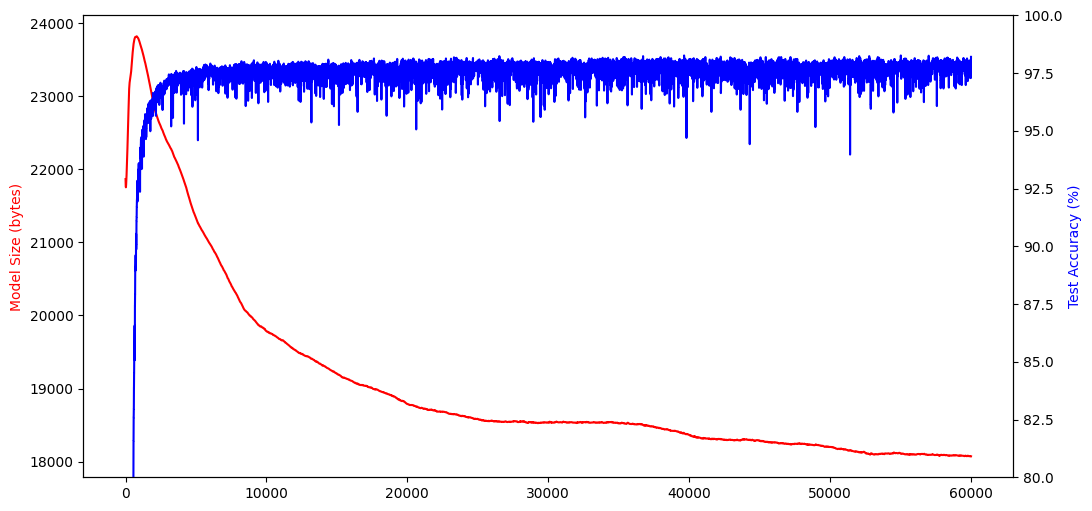

In [11]:
from matplotlib import pyplot as plt
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_ylabel("Model Size (bytes)")
ax1.yaxis.label.set_color("red")
ax1.plot(bytes_used, color="red")
ax2 = ax1.twinx()
ax2.plot(test_accs, color="blue")
plt.ylim(80, 100)
ax2.set_ylabel("Test Accuracy (%)")
ax2.yaxis.label.set_color("blue")

In [12]:
import numpy as np
np.set_printoptions(suppress=True, linewidth=200)
for k,v in nn.state.get_state_dict(model).items():
  if k.endswith(".b") or k.endswith(".e"):
    print(k, v.shape, v.numpy().flatten()[0:10])
from collections import Counter
for i,l in enumerate(model.layers):
  if isinstance(l, QConv2d):
    print(f"QConv2d {i} weights", [x[1] for x in sorted(Counter(l.qweight().round().numpy().flatten().tolist()).items())])

layers.0.e (32, 1, 1, 1) [-7.8823347 -7.654231  -8.489288  -8.361537  -7.701483  -7.132944  -9.137187  -9.193299  -8.657575  -7.774302 ]
layers.0.b (32, 1, 1, 1) [ 2.5145702   2.3283026  -0.00623726  2.3242717   2.805374    3.2020466   2.332345    3.1702843   3.5179725   2.9074616 ]
layers.2.e (32, 1, 1, 1) [-12.307058  -12.821273   -8.021585   -7.9287987  -8.49148   -12.861855  -11.645621   -8.145762   -8.0428295  -9.375334 ]
layers.2.b (32, 1, 1, 1) [ 2.3977613   2.323245    2.3247752  -0.00897927 -0.00666291  2.3268156   2.3121285  -0.00704595 -0.0092365   2.8098247 ]
layers.6.e (64, 1, 1, 1) [-8.37671   -7.931932  -7.3350105 -7.47068   -7.9905834 -6.9589396 -7.1350765 -7.114615  -8.353732  -8.322292 ]
layers.6.b (64, 1, 1, 1) [ 2.3292553   3.5319302   2.8099465  -0.00552724 -0.00761819 -0.00646825  1.5823233   2.3226957  -0.002984    3.2326133 ]
layers.8.e (64, 1, 1, 1) [-7.8625555 -7.6242867 -7.8881006 -8.019431  -7.2809896 -7.1702027 -7.9212527 -8.03808   -7.9698157 -8.127156 ]
l